In [1]:
import os

import numpy as np
import pandas as pd
import re
import paramiko
from getpass import getpass
import traceback
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

/home/stotoshka/Soft/anaconda3/envs/research/lib/python3.9/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
os.chdir("/home/stotoshka/Documents/ANGEL_dev")

In [68]:
%%bash
cd /home/stotoshka/Documents/ANGEL_dev
python Proteasome/in_vitro/prepareValidation.py -t C -w 2

/home/stotoshka/Documents/ANGEL_dev/Proteasome/in_vitro/prepareValidation.py:53: FutureWarning: The default value of regex will change from True to False in a future version.
  calis_data_filtered["sequence"] = calis_data_filtered["cleavage_sites"].str.replace("\\|","")
/home/stotoshka/Documents/ANGEL_dev/Proteasome/in_vitro/prepareValidation.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calis_data_filtered["sequence"] = calis_data_filtered["cleavage_sites"].str.replace("\\|","")


0    1745
1    1384
Name: activity, dtype: int64
Num train substrate = 88
Num validation substrate = 214
0    1650
1     637
Name: activity, dtype: int64


In [46]:
%%time
path_to_config = "Proteasome/in_vitro/const/converter_config.json"
command = f"python tools/generateConfigForConverter.py -i {os.path.join(os.getcwd(),'Proteasome/in_vitro/const/validation/ready_train_const_2.csv')} -o {os.path.join(os.getcwd(),'Proteasome/in_vitro/const/sdf')} -c peptide -t 10 {path_to_config}"
os.system(command)
print("Convertation")
convert_command = f"python tools/SeqToSDF.py {path_to_config}"
os.system(convert_command)

Success
Convertation
Success
--- 0.4368584156036377 seconds ---
CPU times: user 1.92 ms, sys: 0 ns, total: 1.92 ms
Wall time: 758 ms


0

In [69]:
%%time
path_to_config = "Proteasome/in_vitro/const/converter_config.json"
command = f"python tools/generateConfigForConverter.py -i {os.path.join(os.getcwd(),'Proteasome/in_vitro/const/validation/ready_validation_const_2.csv')} -o {os.path.join(os.getcwd(),'Proteasome/in_vitro/const/sdf')} -c peptide -t 10 {path_to_config}"
os.system(command)
print("Convertation")
convert_command = f"python tools/SeqToSDF.py {path_to_config}"
os.system(convert_command)

Success
Convertation
Success
--- 0.4181962013244629 seconds ---
CPU times: user 1.94 ms, sys: 121 µs, total: 2.07 ms
Wall time: 759 ms


0

In [70]:
%%bash
cd /home/stotoshka/Documents/ANGEL_dev
rm Proteasome/in_vitro/const/sdf/*.txt
cp Proteasome/in_vitro/const/sdf/ready_train_const_2.sdf /run/user/1000/gvfs/smb-share:server=192.168.0.10,share=diplom/ANGEL/const/sdf
cp Proteasome/in_vitro/const/sdf/ready_validation_const_2.sdf /run/user/1000/gvfs/smb-share:server=192.168.0.10,share=diplom/ANGEL/const/sdf

In [49]:
command = f"python tools/generateConfigForTrain.py -l {7} -b total_const_2_7 -s sdf/ready_train_const_2.sdf -a activity -p models/total_const_2_7 /run/user/1000/gvfs/smb-share:server=192.168.0.10,share=diplom/ANGEL/const/total_const_2_7_tr.txt"
os.system(command)

Success


0

In [80]:
command = f"python tools/generateConfigForPrediction.py -m models/total_const_2_7.MSAR -s sdf/ready_validation_const_2.sdf -a sequence -p results /run/user/1000/gvfs/smb-share:server=192.168.0.10,share=diplom/ANGEL/const/total_const_2_7_val.txt"
os.system(command)

Success


0

In [81]:
def checkTrain(path):
    flag = False
    header = "No	 Check	 Number	 IAP	 20-Fold	 Activity Type"
    try:
        with open(path, "r", encoding="cp1252") as log:
            for line in log:
                if header in line:
                    flag = True
    except:
        traceback.print_exc()
    finally:
        return flag


def checkValidation(path):
    try:
        f = False
        with open(path, "r", encoding="cp1252") as log:
            for line in log:
                if "are predicted" in line:
                    comps = line.strip().split(" ")
                    if int(comps[0]) == int(comps[2]):
                        f = True
                    else:
                        f = False
    except:
        traceback.print_exc()
    finally:
        return f

In [59]:
%%time
client = paramiko.SSHClient()
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
password = getpass()
client.connect('192.168.0.10', username='SmirnygaTotoshka', password=password)

tr_command = r"C:\Users\SmirnygaTotoshka\Desktop\OLMPASS\OLMPASSdoSAR.exe C:\Users\SmirnygaTotoshka\Desktop\diplom\ANGEL\const\total_const_2_7_tr.txt"
stdin, stdout, stderr = client.exec_command(tr_command)  # Non-blocking call
exit_status = stdout.channel.recv_exit_status()  # Blocking call
if exit_status == 0:
    if checkTrain(f"/run/user/1000/gvfs/smb-share:server=192.168.0.10,share=diplom/ANGEL/const/models/total_const_2_7.HST"):
        print("Train ended")
    else:
        print(f"Train ended with errors")
else:
    print("Error", exit_status)
client.close()

Socket exception: Connection reset by peer (104)
Socket exception: Connection reset by peer (104)


Train ended
CPU times: user 238 ms, sys: 76.4 ms, total: 315 ms
Wall time: 1min 39s


In [82]:
%%time
client.connect('192.168.0.10', username='SmirnygaTotoshka', password=password)
val_command = r"C:\Users\SmirnygaTotoshka\Desktop\OLMPASS\OLMPASS2CSV.exe C:\Users\SmirnygaTotoshka\Desktop\diplom\ANGEL\const\total_const_2_7_val.txt"
stdin_val, stdout_val, stderr_val = client.exec_command(val_command)  # Non-blocking call
exit_status_val = stdout_val.channel.recv_exit_status()
if exit_status_val == 0:
    if checkValidation(f"/run/user/1000/gvfs/smb-share:server=192.168.0.10,share=diplom/ANGEL/const/results/ready_validation_const_2-total_const_2_7.HST"):
        print("Validation ended")
    else:
        print(f"Validation ended with errors")
else:
    print("Error validation", exit_status_val)
client.close()

Validation ended with errors
CPU times: user 36.1 ms, sys: 547 µs, total: 36.7 ms
Wall time: 9.62 s


In [83]:
%%bash
cd /home/stotoshka/Documents/ANGEL_dev
cp /run/user/1000/gvfs/smb-share:server=192.168.0.10,share=diplom/ANGEL/const/models/total* Proteasome/in_vitro/const/results/validation/models/
cp /run/user/1000/gvfs/smb-share:server=192.168.0.10,share=diplom/ANGEL/const/results/ready_validation* Proteasome/in_vitro/const/results/validation/results

In [73]:
path = f"Proteasome/in_vitro/const/results/validation/models/total_const_2_7.HST"
header = "No	 Check	 Number	 IAP	 20-Fold	 Activity"
tbl = pd.DataFrame(columns=["model_name","window", "descriptor_level", "iap", "twentyCV", "activity", "num_subst"])
with open(path, "r", encoding='cp1252') as f:
    split_name = re.split("_", os.path.splitext(os.path.basename(path))[0])
    model_name = split_name[1]
    window = split_name[2]
    level = split_name[3]
    lines = f.readlines()
    flag = False
    for line in lines:
        if header in line:
            flag = True
            continue
        if line == "\n" and flag:
            break
        if flag:
            components = re.split("\t\\s+", line)
            num_subst = components[2]
            iap = components[3]
            twentyCV = components[4]
            activity = components[5].strip()
            row = pd.DataFrame.from_dict({"model_name": [model_name],
                                          "window":[int(window)],
                                          "descriptor_level": [int(level)],
                                          "num_subst": [int(num_subst)],
                                          "iap": [float(iap.replace(",", "."))],
                                          "twentyCV": [float(twentyCV.replace(",", "."))],
                                          "activity": [int(activity)]})
            tbl = pd.concat([tbl, row], ignore_index=True)
    if not flag:
        print(f"total not any predictable activity")
tbl.to_excel("Proteasome/in_vitro/const/results/validation/internal.xlsx", index = False)

In [74]:
internal_res = pd.read_excel("Proteasome/in_vitro/const/results/validation/internal.xlsx")
internal_res.head()

,model_name,window,descriptor_level,iap,twentyCV,activity,num_subst
0,const,2,7,0.6786,0.6798,1,1247
1,const,2,7,0.6746,0.6759,0,1621


In [3]:
def deconvoluteTrue(X, excluded=None):
    seqs = list(X["substrate"].unique())
    for i in X.index:
        finded_start = X.loc[i, "substrate"].find(X.loc[i, "fragment"])
        X.loc[i, "start"] = finded_start - 1  # сайт левее найденной позиции (левее N-конца)
        X.loc[i, "end"] = finded_start + len(X.loc[i, "fragment"]) - 1  # сайт левее найденной позиции (C-конец)
    result = pd.DataFrame(columns=["residue", "sequence", "activity"])
    k = 0
    for s in seqs:
        subset = X.query("substrate == @s").reset_index(drop=True)
        start = list(subset['start'])
        end = list(subset['end'])
        for i in range(0, len(s)):
            if excluded is not None:
                if not pd.isna(subset.loc[0,excluded]):
                    ex = subset.loc[0, excluded].split(";")
                else:
                    ex = []
                if i in ex:
                    result.loc[k] = [s[i], s, 0]
                else:
                    result.loc[k] = [s[i], s, int(i in start or i in end)]
            else:
                result.loc[k] = [s[i], s, int(i in start or i in end)]
            k += 1
    print(result.activity.value_counts())
    return result

In [4]:
sample = pd.read_csv("Proteasome/in_vitro/const/validation/ready_validation_const_2.csv",sep = ";")
sample.head()

,peptide,sequence,full_sequence,activity
0,ALETG,ALETG,ALETGTIFLPVRHD,0
1,LETGT,LETGT,ALETGTIFLPVRHD,1
2,ETGTI,ETGTI,ALETGTIFLPVRHD,0
3,TGTIF,TGTIF,ALETGTIFLPVRHD,0
4,GTIFL,GTIFL,ALETGTIFLPVRHD,0


In [5]:
prediction = pd.read_csv("Proteasome/in_vitro/const/results/validation/results/ready_validation_const_2-total_const_2_7.csv",sep = ";", header = 0,decimal=",")
prediction = prediction.drop(columns=["Substructure Descriptors", "New Descriptors", "Possible Activities at Pa>Pi"])
prediction.head()

,sequence,1,0
0,ALETG,-0.0755,-0.0061
1,LETGT,-0.5346,0.5043
2,ETGTI,-0.2856,0.2073
3,TGTIF,-0.5881,0.5598
4,GTIFL,0.3673,-0.3944


In [6]:
j = sample.index[0]
flag = True
for i in sample.index:
    if flag:
        j = i
    else:
        j += 1
    if sample.loc[i,"peptide"] == prediction.loc[j,"sequence"]:
        sample.loc[i,"pred"] = prediction.loc[j,"1"]
        sample.loc[i,"pred_pep"] = prediction.loc[j,"sequence"]
    else:
        flag = False
        print(f"Mismatch {i} {sample.loc[i,'peptide']} {j} {prediction.loc[j,'sequence']}")
        sample.loc[i,"pred"] = 0

sample

,peptide,sequence,full_sequence,activity,pred,pred_pep
0,ALETG,ALETG,ALETGTIFLPVRHD,0,-0.0755,ALETG
1,LETGT,LETGT,ALETGTIFLPVRHD,1,-0.5346,LETGT
2,ETGTI,ETGTI,ALETGTIFLPVRHD,0,-0.2856,ETGTI
3,TGTIF,TGTIF,ALETGTIFLPVRHD,0,-0.5881,TGTIF
4,GTIFL,GTIFL,ALETGTIFLPVRHD,0,0.3673,GTIFL
...,...,...,...,...,...,...
2282,TMLNT,TMLNT,PEVIPMFSALSEGATPQDLNTMLNTVGGH,1,0.4137,TMLNT
2283,MLNTV,MLNTV,PEVIPMFSALSEGATPQDLNTMLNTVGGH,0,0.2455,MLNTV
2284,LNTVG,LNTVG,PEVIPMFSALSEGATPQDLNTMLNTVGGH,0,0.2945,LNTVG
2285,NTVGG,NTVGG,PEVIPMFSALSEGATPQDLNTMLNTVGGH,0,0.0168,NTVGG


In [7]:
window = 2
result = pd.DataFrame(columns=["residue","full_seq", "peptide","prediction"])
unique_fulls = sample.full_sequence.unique()
k = 0
for seq in unique_fulls:
    subset = sample.query("full_sequence == @seq")
    sub_i = 0
    for i,r in enumerate(seq):
        if i < window or i > len(seq)-window-1:
            result.loc[k] = [r,seq,"",0]
            k+=1
        else:
            pos = subset.index[sub_i]
            result.loc[k] = [r,seq,subset.loc[pos,"peptide"],subset.loc[pos,"pred"]]
            k+=1
            sub_i+=1

result

,residue,full_seq,peptide,prediction
0,A,ALETGTIFLPVRHD,,0.0000
1,L,ALETGTIFLPVRHD,,0.0000
2,E,ALETGTIFLPVRHD,ALETG,-0.0755
3,T,ALETGTIFLPVRHD,LETGT,-0.5346
4,G,ALETGTIFLPVRHD,ETGTI,-0.2856
...,...,...,...,...
3138,T,PEVIPMFSALSEGATPQDLNTMLNTVGGH,LNTVG,0.2945
3139,V,PEVIPMFSALSEGATPQDLNTMLNTVGGH,NTVGG,0.0168
3140,G,PEVIPMFSALSEGATPQDLNTMLNTVGGH,TVGGH,-0.3517
3141,G,PEVIPMFSALSEGATPQDLNTMLNTVGGH,,0.0000


In [8]:
result.to_excel("Proteasome/in_vitro/const/results/validation/angel.xlsx")

In [9]:
angel_result = pd.DataFrame(columns=["residue", "sequence", "true","prediction"])
total_validation = pd.read_csv("Proteasome/in_vitro/const/validation/total_validation_const.csv",sep = ";")
true = deconvoluteTrue(total_validation,"exclusions")
true

0    2401
1     742
Name: activity, dtype: int64


,residue,sequence,activity
0,A,ALETGTIFLPVRHD,0
1,L,ALETGTIFLPVRHD,0
2,E,ALETGTIFLPVRHD,0
3,T,ALETGTIFLPVRHD,1
4,G,ALETGTIFLPVRHD,0
...,...,...,...
3138,T,PEVIPMFSALSEGATPQDLNTMLNTVGGH,0
3139,V,PEVIPMFSALSEGATPQDLNTMLNTVGGH,0
3140,G,PEVIPMFSALSEGATPQDLNTMLNTVGGH,0
3141,G,PEVIPMFSALSEGATPQDLNTMLNTVGGH,0


In [10]:
true["ANGEL"] = result["prediction"]

In [21]:
(true["residue"] == result['residue']).sum() == len(true.index)

True

In [22]:
true["ANGEL"] = result["prediction"]

In [11]:
true

,residue,sequence,activity,ANGEL
0,A,ALETGTIFLPVRHD,0,0.0000
1,L,ALETGTIFLPVRHD,0,0.0000
2,E,ALETGTIFLPVRHD,0,-0.0755
3,T,ALETGTIFLPVRHD,1,-0.5346
4,G,ALETGTIFLPVRHD,0,-0.2856
...,...,...,...,...
3138,T,PEVIPMFSALSEGATPQDLNTMLNTVGGH,0,0.2945
3139,V,PEVIPMFSALSEGATPQDLNTMLNTVGGH,0,0.0168
3140,G,PEVIPMFSALSEGATPQDLNTMLNTVGGH,0,-0.3517
3141,G,PEVIPMFSALSEGATPQDLNTMLNTVGGH,0,0.0000


In [24]:
roc = metrics.roc_auc_score(true["activity"],true["ANGEL"])
ap = metrics.average_precision_score(true["activity"],true["ANGEL"])
print(roc,ap)

0.6222474687658219 0.3212639603673641


In [25]:
with open("Proteasome/in_vitro/const/validation/val_seqs.txt","w") as txt:
    unique_fulls = sample.full_sequence.unique()
    for f in unique_fulls:
        txt.write(f"{f}\n")

In [26]:
%%bash
cd /home/stotoshka/Documents/ANGEL_dev
time python Proteasome/competitors/runNetChop.py -t vitro Proteasome/in_vitro/const/validation/val_seqs.txt Proteasome/in_vitro/const/results/validation/netchop.xlsx

[WDM] - Downloading: 100%|██████████| 6.75M/6.75M [00:00<00:00, 19.2MB/s]


0 Finish
1 Finish
2 Finish
3 Finish
4 Finish
5 Finish
6 Finish
7 Finish
8 Finish
9 Finish
10 Finish
11 Finish
12 Finish
13 Finish
14 Finish
15 Finish
16 Finish
17 Finish
18 Finish
19 Finish
20 Finish
21 Finish
22 Finish
23 Finish
24 Finish
25 Finish
26 Finish
27 Finish
28 Finish
29 Finish
30 Finish
31 Finish
32 Finish
33 Finish
34 Finish
35 Finish
36 Finish
37 Finish
38 Finish
39 Finish
40 Finish
41 Finish
42 Finish
43 Finish
44 Finish
45 Finish
46 Finish
47 Finish
48 Finish
49 Finish
50 Finish
51 Finish
52 Finish
53 Finish
54 Finish
55 Finish
56 Finish
57 Finish
58 Finish
59 Finish
60 Finish
61 Finish
62 Finish
63 Finish
64 Finish
65 Finish
66 Finish
67 Finish
68 Finish
69 Finish
70 Finish
71 Finish
72 Finish
73 Finish
74 Finish
75 Finish
76 Finish
77 Finish
78 Finish
79 Finish
80 Finish
81 Finish
82 Finish
83 Finish
84 Finish
85 Finish
86 Finish
87 Finish
88 Finish
89 Finish
90 Finish
91 Finish
92 Finish
93 Finish
94 Finish
95 Finish
96 Finish
97 Finish
98 Finish
99 Finish
100 Finish


real	20m5.572s
user	0m9.128s
sys	0m0.357s


In [27]:
%%bash
cd /home/stotoshka/Documents/ANGEL_dev
time python Proteasome/competitors/runPepsickle.py -t C -m in-vitro Proteasome/in_vitro/const/validation/val_seqs.txt Proteasome/in_vitro/const/results/validation/pepsickle_in_vitro.xlsx

conda run -p /home/stotoshka/Soft/anaconda3/envs/pepsickle-v0-2-1/ pepsickle -f Proteasome/in_vitro/const/validation/pepsickle_tmp.fasta -m in-vitro -p C --human-only >> Proteasome/in_vitro/const/validation/pepsickle_result.txt
Finish



real	0m4.781s
user	0m3.531s
sys	0m1.459s


In [28]:
%%bash
cd /home/stotoshka/Documents/ANGEL_dev
time python Proteasome/competitors/runPepsickle.py -t C -m in-vitro-2 Proteasome/in_vitro/const/validation/val_seqs.txt Proteasome/in_vitro/const/results/validation/pepsickle_in_vitro_2.xlsx

conda run -p /home/stotoshka/Soft/anaconda3/envs/pepsickle-v0-2-1/ pepsickle -f Proteasome/in_vitro/const/validation/pepsickle_tmp.fasta -m in-vitro-2 -p C --human-only >> Proteasome/in_vitro/const/validation/pepsickle_result.txt
Finish



real	0m3.085s
user	0m4.228s
sys	0m1.259s


In [29]:
%%bash
cd /home/stotoshka/Documents/ANGEL_dev
time python Proteasome/competitors/runPCPS.py -t C Proteasome/in_vitro/const/validation/val_seqs.txt Proteasome/in_vitro/const/results/validation

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0
4 1
4 2
5 0
5 1
5 2
6 0
6 1
6 2
7 0
7 1
7 2
8 0
8 1
8 2
9 0
9 1
9 2
10 0
10 1
10 2
11 0
11 1
11 2
12 0
12 1
12 2
13 0
13 1
13 2
14 0
14 1
14 2
15 0
15 1
15 2
16 0
16 1
16 2
17 0
17 1
17 2
18 0
18 1
18 2
19 0
19 1
19 2
20 0
20 1
20 2
21 0
21 1
21 2
22 0
22 1
22 2
23 0
23 1
23 2
24 0
24 1
24 2
25 0
25 1
25 2
26 0
26 1
26 2
27 0
27 1
27 2
28 0
28 1
28 2
29 0
29 1
29 2
30 0
30 1
30 2
31 0
31 1
31 2
32 0
32 1
32 2
33 0
33 1
33 2
34 0
34 1
34 2
35 0
35 1
35 2
36 0
36 1
36 2
37 0
37 1
37 2
38 0
38 1
38 2
39 0
39 1
39 2
40 0
40 1
40 2
41 0
41 1
41 2
42 0
42 1
42 2
43 0
43 1
43 2
44 0
44 1
44 2
45 0
45 1
45 2
46 0
46 1
46 2
47 0
47 1
47 2
48 0
48 1
48 2
49 0
49 1
49 2
50 0
50 1
50 2
51 0
51 1
51 2
52 0
52 1
52 2
53 0
53 1
53 2
54 0
54 1
54 2
55 0
55 1
55 2
56 0
56 1
56 2
57 0
57 1
57 2
58 0
58 1
58 2
59 0
59 1
59 2
60 0
60 1
60 2
61 0
61 1
61 2
62 0
62 1
62 2
63 0
63 1
63 2
64 0
64 1
64 2
65 0
65 1
65 2
66 0
66 1
66 2
67 0
67 1
67 2
68 0
68 1



real	80m53.868s
user	0m24.728s
sys	0m1.086s


In [30]:
%%bash
cd /home/stotoshka/Documents/ANGEL_dev
time python Proteasome/competitors/runPcleavage.py -t vitro Proteasome/in_vitro/const/validation/val_seqs.txt Proteasome/in_vitro/const/results/validation/pcleavage.xlsx

0 Finish
1 Finish
2 Finish
3 Finish
4 Finish
5 Finish
6 Finish
7 Finish
8 Finish
9 Finish
10 Finish
11 Finish
12 Finish
13 Finish
14 Finish
15 Finish
16 Finish
17 Finish
18 Finish
19 Finish
20 Finish
21 Finish
22 Finish
23 Finish
24 Finish
25 Finish
26 Finish
27 Finish
28 Finish
29 Finish
30 Finish
31 Finish
32 Finish
33 Finish
34 Finish
35 Finish
36 Finish
37 Finish
38 Finish
39 Finish
40 Finish
41 Finish
42 Finish
43 Finish
44 Finish
45 Finish
46 Finish
47 Finish
48 Finish
49 Finish
50 Finish
51 Finish
52 Finish
53 Finish
54 Finish
55 Finish
56 Finish
57 Finish
58 Finish
59 Finish
60 Finish
61 Finish
62 Finish
63 Finish
64 Finish
65 Finish
66 Finish
67 Finish
68 Finish
69 Finish
70 Finish
71 Finish
72 Finish
73 Finish
74 Finish
75 Finish
76 Finish
77 Finish
78 Finish
79 Finish
80 Finish
81 Finish
82 Finish
83 Finish
84 Finish
85 Finish
86 Finish
87 Finish
88 Finish
89 Finish
90 Finish
91 Finish
92 Finish
93 Finish
94 Finish
95 Finish
96 Finish
97 Finish
98 Finish
99 Finish
100 Finish


real	2m36.653s
user	0m2.470s
sys	0m0.141s


In [12]:
netchop = pd.read_excel("Proteasome/in_vitro/const/results/validation/netchop.xlsx")
pcleavage = pd.read_excel("Proteasome/in_vitro/const/results/validation/pcleavage.xlsx")
pcps_1 = pd.read_excel("Proteasome/in_vitro/const/results/validation/pcps_1.xlsx")
pcps_2 = pd.read_excel("Proteasome/in_vitro/const/results/validation/pcps_2.xlsx")
pcps_3 = pd.read_excel("Proteasome/in_vitro/const/results/validation/pcps_3.xlsx")
pepsickle_1 = pd.read_excel("Proteasome/in_vitro/const/results/validation/pepsickle_in_vitro.xlsx")
pepsickle_2 = pd.read_excel("Proteasome/in_vitro/const/results/validation/pepsickle_in_vitro_2.xlsx")

In [13]:
netchop.head()

,pos,AA,C,score,Ident,sequence
0,1,A,.,0.169093,0,ALETGTIFLPVRHD\n
1,2,L,S,0.601548,0,ALETGTIFLPVRHD\n
2,3,E,S,0.522118,0,ALETGTIFLPVRHD\n
3,4,T,.,0.450576,0,ALETGTIFLPVRHD\n
4,5,G,S,0.570392,0,ALETGTIFLPVRHD\n


In [14]:
pcleavage.head()

,Position,Amino Acid,State,Score,sequence
0,1,A,N,-0.70,ALETGTIFLPVRHD\n
1,2,L,N,-0.50,ALETGTIFLPVRHD\n
2,3,E,N,-0.31,ALETGTIFLPVRHD\n
3,4,T,N,-0.22,ALETGTIFLPVRHD\n
4,5,G,S,0.33,ALETGTIFLPVRHD\n


In [15]:
pcps_1.head()

,Aminoacid,Proteasome Cleavage,Score,sequence
0,A,NaN,0.0979,ALETGTIFLPVRHD\n
1,L,NaN,0.6459,ALETGTIFLPVRHD\n
2,E,NaN,0.0115,ALETGTIFLPVRHD\n
3,T,NaN,0.0349,ALETGTIFLPVRHD\n
4,G,NaN,0.0239,ALETGTIFLPVRHD\n


In [16]:
pepsickle_1.head()

,position,residue,cleav_prob,cleaved,protein_id
0,1,A,0.0762,False,ALETGTIFLPVRHD
1,2,L,0.3886,False,ALETGTIFLPVRHD
2,3,E,0.4286,False,ALETGTIFLPVRHD
3,4,T,0.6097,True,ALETGTIFLPVRHD
4,5,G,0.5167,True,ALETGTIFLPVRHD


In [17]:
true["netchop"] = netchop["score"]
true["pcleavage"] = pcleavage["Score"]
true["pcps_1"] = pcps_1["Score"]
true["pcps_2"] = pcps_2["Score"]
true["pcps_3"] = pcps_3["Score"]
true["pepsickle_1"] = pepsickle_1["cleav_prob"]
true["pepsickle_2"] = pepsickle_2["cleav_prob"]

In [19]:
print(f"ANGEL AUC={metrics.roc_auc_score(true['activity'],true['ANGEL'])} AP={metrics.average_precision_score(true['activity'],true['ANGEL'])}")
print(f"netchop AUC={metrics.roc_auc_score(true['activity'],true['netchop'])} AP={metrics.average_precision_score(true['activity'],true['netchop'])}")
print(f"pcleavage AUC={metrics.roc_auc_score(true['activity'],true['pcleavage'])} AP={metrics.average_precision_score(true['activity'],true['pcleavage'])}")
print(f"pcps_1 AUC={metrics.roc_auc_score(true['activity'],true['pcps_1'])} AP={metrics.average_precision_score(true['activity'],true['pcps_1'])}")
print(f"pcps_2 AUC={metrics.roc_auc_score(true['activity'],true['pcps_2'])} AP={metrics.average_precision_score(true['activity'],true['pcps_2'])}")
print(f"pcps_3 AUC={metrics.roc_auc_score(true['activity'],true['pcps_3'])} AP={metrics.average_precision_score(true['activity'],true['pcps_3'])}")
print(f"pepsickle_1 AUC={metrics.roc_auc_score(true['activity'],true['pepsickle_1'])} AP={metrics.average_precision_score(true['activity'],true['pepsickle_1'])}")
print(f"pepsickle_2 AUC={metrics.roc_auc_score(true['activity'],true['pepsickle_2'])} AP={metrics.average_precision_score(true['activity'],true['pepsickle_2'])}")

ANGEL AUC=0.6222474687658219 AP=0.3212639603673641
netchop AUC=0.6933667575617077 AP=0.3859257335521086
pcleavage AUC=0.6680462767647353 AP=0.35556372798082336
pcps_1 AUC=0.6573530121658655 AP=0.36451203974685253
pcps_2 AUC=0.6553945963665184 AP=0.3656149004393586
pcps_3 AUC=0.651462328701765 AP=0.3509966914962307
pepsickle_1 AUC=0.8074434955785494 AP=0.5227011892854332
pepsickle_2 AUC=0.7669692884029677 AP=0.4512713051758792


In [20]:
angel_fpr, angel_tpr, angel_thres = metrics.roc_curve(true['activity'],true['ANGEL'])
netchop_fpr, netchop_tpr, netchop_thres = metrics.roc_curve(true['activity'],true['netchop'])
pcleavage_fpr, pcleavage_tpr, pcleavage_thres = metrics.roc_curve(true['activity'],true['pcleavage'])
pcps_1_fpr, pcps_1_tpr, pcps_1_thres = metrics.roc_curve(true['activity'],true['pcps_1'])
pcps_2_fpr, pcps_2_tpr, pcps_2_thres = metrics.roc_curve(true['activity'],true['pcps_2'])
pcps_3_fpr, pcps_3_tpr, pcps_3_thres = metrics.roc_curve(true['activity'],true['pcps_3'])
pepsickle_1_fpr, pepsickle_1_tpr, pepsickle_1_thres = metrics.roc_curve(true['activity'],true['pepsickle_1'])
pepsickle_2_fpr, pepsickle_2_tpr, pepsickle_2_thres = metrics.roc_curve(true['activity'],true['pepsickle_2'])

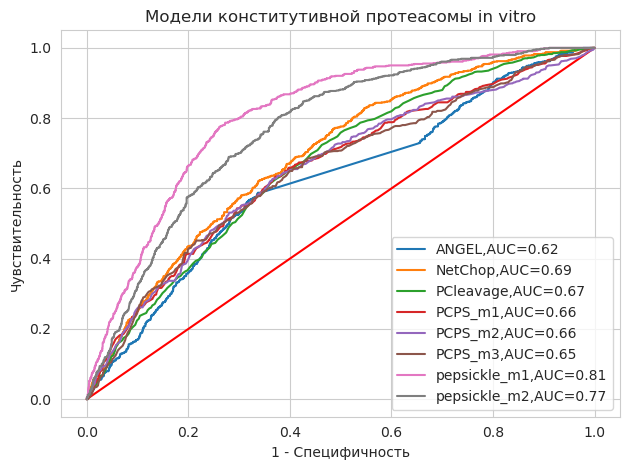

In [22]:
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1), color = "red")
plt.plot(angel_fpr, angel_tpr, label = f"ANGEL,AUC={round(metrics.roc_auc_score(true['activity'],true['ANGEL']),2)}")
plt.plot(netchop_fpr, netchop_tpr, label = f"NetChop,AUC={round(metrics.roc_auc_score(true['activity'],true['netchop']),2)}")
plt.plot(pcleavage_fpr, pcleavage_tpr, label = f"PCleavage,AUC={round(metrics.roc_auc_score(true['activity'],true['pcleavage']),2)}")
plt.plot(pcps_1_fpr, pcps_1_tpr, label = f"PCPS_m1,AUC={round(metrics.roc_auc_score(true['activity'],true['pcps_1']),2)}")
plt.plot(pcps_2_fpr, pcps_2_tpr, label = f"PCPS_m2,AUC={round(metrics.roc_auc_score(true['activity'],true['pcps_2']),2)}")
plt.plot(pcps_3_fpr, pcps_3_tpr, label = f"PCPS_m3,AUC={round(metrics.roc_auc_score(true['activity'],true['pcps_3']),2)}")
plt.plot(pepsickle_1_fpr, pepsickle_1_tpr, label = f"pepsickle_m1,AUC={round(metrics.roc_auc_score(true['activity'],true['pepsickle_1']),2)}")
plt.plot(pepsickle_2_fpr, pepsickle_2_tpr, label = f"pepsickle_m2,AUC={round(metrics.roc_auc_score(true['activity'],true['pepsickle_2']),2)}")
plt.xlabel("1 - Специфичность")
plt.ylabel("Чувствительность")
plt.title("Модели конститутивной протеасомы in vitro")
plt.legend()
plt.tight_layout()
plt.savefig("Proteasome/in_vitro/const/results/validation/plots/roc.png")